# Notebook

1. Quais foram os principais motivos que fizeram o NPS cair nos meses de abril, maio e junho? Foram motivos diferentes ou há algum problema que é constante em todos os meses?
2. Avaliando todos os pontos de contato da jornada, você identifica alguma oportunidade que precisa ser direcionada para tratativa das equipes responsáveis?
3. Há alguma relação entre os indicadores operacionais e os dados coletados na base de dados da Pesquisa NPS?
4. Para enriquecer essa análise, você sente necessidade de explorar alguma informação adicional além dos dados trazidos nesse estudo? Se sim, quais indicadores você buscaria para cruzar com os dados que você já possui?




In [1]:
# Manipulação
import numpy as np
import pandas as pd
import azul_nps as azul

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Teste estatísticos
from scipy import stats

## 1. Extração

In [2]:
# Aba 1: NPS
df_nps_raw = pd.read_excel('Case_Análise Semestral - NPS - V2.xlsx', sheet_name='BASE_DADOS_NPS')
df_nps_raw.head(1)

,Id,Data_Voo,Minutos_Atraso,Tempo_Voo,AirportLegs,Equipamento_Tipo,Nota_Principal,Nota_CheckinWeb,Nota_CheckinMobile,Nota_Comissarios,...,O processo de check in web funcionou corretamente?,O processo de check in web foi simples?,O processo de check in pelo celular foi simples?,O processo de check in pelo celular funcionou corretamente?,O sistema de entretenimento apresentou algum problema durante o voo?,Qual foi o problema?,Foi oferecido fone a bordo?,O tempo de espera pela bagagem no destino foi satisfatório?,Você ficou satisfeito com as condições de sua bagagem na devolução?,Você ficou satisfeito com o atendimento em caso de dano/extravio?
0,1814257,2022-01-01 00:00:00,0.0,210,REC/GRU,A320,10,NaN,10.0,10.0,...,NaN,NaN,Sim,Sim,NaN,NaN,NaN,Não,Sim,NaN


In [3]:
# Aba 2: outros indicadores
df_kpi_raw = pd.read_excel('Case_Análise Semestral - NPS - V2.xlsx', sheet_name='Outros Indicadores')
df_kpi_raw.head(1)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,Indicador,jan/22,fev/22,mar/22,abr/22,mai/22,jun/22


## 2. Processamento

In [4]:
# Correção de inconsistências na base de NPS.
df_nps = df_nps_raw.copy(deep=True)

df_nps['validacao'] = np.select(
    [
        # Caso 1: datas inexistentes.
        df_nps['Data_Voo'].astype(str).str.contains('29/02'),
        
        # Caso 2: durações igual/menores que 0.
        df_nps_raw['Tempo_Voo'] <= 0
    ],
    [
        'erro 1: data',
        'erro 2: duracao'
    ], 'ok'
)

print(f"Validação dos dados:\n{df_nps['validacao'].value_counts()}")

Validação dos dados:
ok                 2870
erro 1: data         18
erro 2: duracao       2
Name: validacao, dtype: int64


In [5]:
# Preprocessamento de NPS.
df_nps = df_nps.loc[df_nps['validacao'] == 'ok'].reset_index(drop=True)
df_nps['Data_Voo'] = pd.to_datetime(df_nps['Data_Voo'], format='%Y-%m-%d %H:%M:%S')

In [6]:
# Classificar as categorias de NPS para cada avaliação (útil para o cálculo futuro de NPS)
list_notas = df_nps.columns[6:12]
display(list_notas)

for i in list_notas:
    df_nps[f"perfil_{i}"] = np.select(
        [
            df_nps[i] <=6,
            df_nps[i].between(7, 8),
            df_nps[i] >=9,
        ],
        ['detrator', 'neutro', 'promotor'], 'sem_avaliacao'
    )

Index(['Nota_Principal', 'Nota_CheckinWeb', 'Nota_CheckinMobile',
       'Nota_Comissarios', 'Nota_Entretenimento', 'Nota_Bagagem'],
      dtype='object')

In [7]:
#df_nps.head(2)
df_nps.columns

Index(['Id', 'Data_Voo', 'Minutos_Atraso', 'Tempo_Voo', 'AirportLegs',
       'Equipamento_Tipo', 'Nota_Principal', 'Nota_CheckinWeb',
       'Nota_CheckinMobile', 'Nota_Comissarios', 'Nota_Entretenimento',
       'Nota_Bagagem', 'O processo de check in web funcionou corretamente?',
       'O processo de check in web foi simples?',
       'O processo de check in pelo celular foi simples?',
       'O processo de check in pelo celular funcionou corretamente?',
       'O sistema de entretenimento apresentou algum problema durante o voo?',
       'Qual foi o problema?', 'Foi oferecido fone a bordo?',
       'O tempo de espera pela bagagem no destino foi satisfatório?',
       'Você ficou satisfeito com as condições de sua bagagem na devolução?',
       'Você ficou satisfeito com o atendimento em caso de dano/extravio?',
       'validacao', 'perfil_Nota_Principal', 'perfil_Nota_CheckinWeb',
       'perfil_Nota_CheckinMobile', 'perfil_Nota_Comissarios',
       'perfil_Nota_Entretenimento', '

In [8]:
# Processamento dos outros indicadores.
df_kpi = df_kpi_raw.T
df_kpi = df_kpi.iloc[2:, :4].reset_index(drop=True)
df_kpi.columns = ['data', 'dark_flight', 'mbr', 'pontualidade']
df_kpi[['dark_flight', 'mbr', 'pontualidade']]= df_kpi[['dark_flight', 'mbr', 'pontualidade']].astype('float')

df_kpi

,data,dark_flight,mbr,pontualidade
0,jan/22,2.34,1.467711,0.911643
1,fev/22,2.17,1.484345,0.909311
2,mar/22,1.69,1.426646,0.909455
3,abr/22,2.24,1.555159,0.882785
4,mai/22,1.88,1.660000,0.865582
5,jun/22,3.59,2.218820,0.810266


## 3. Exploração

### 3.1 Geral

In [9]:
# Temos realmente um ID por vôo?
print(f"Qtd. de vôos: {df_nps.shape[0]}")
print(f"Qtd. de ids únicos: {df_nps['Id'].nunique()}")

Qtd. de vôos: 2870
Qtd. de ids únicos: 2870


In [10]:
# Realmente temos vôos apenas entre jan/22 a jun22?
print(f"Data do primeiro registro: {df_nps['Data_Voo'].min()}")
print(f"Data do último registro: {df_nps['Data_Voo'].max()}")

Data do primeiro registro: 2022-01-01 00:00:00
Data do último registro: 2022-06-30 00:00:00


In [11]:
# Separando os períodos de comparação.
df_nps['periodo'] = np.where(df_nps['Data_Voo'].between('2022-01-01', '2022-03-31'), 'q1', 'q2')

print('Período de controle:')
display(df_nps.loc[df_nps['periodo'] == 'q1', 'Data_Voo'].min(), df_nps.loc[df_nps['periodo'] == 'q1', 'Data_Voo'].max())

print('Período de avaliação:')
display(df_nps.loc[df_nps['periodo'] == 'q2', 'Data_Voo'].min(), df_nps.loc[df_nps['periodo'] == 'q2', 'Data_Voo'].max())

Período de controle:


Timestamp('2022-01-01 00:00:00')

Timestamp('2022-03-31 00:00:00')

Período de avaliação:


Timestamp('2022-04-01 00:00:00')

Timestamp('2022-06-30 00:00:00')

,0,5,1,3,2,4
index,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01
mes,541,405,530,461,522,411


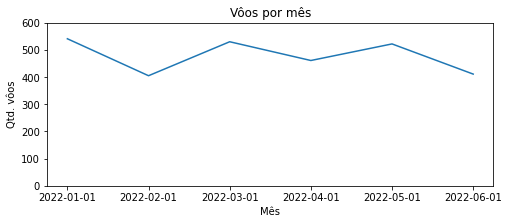

In [12]:
# Quantos registros por mês?
df_nps['mes'] = df_nps['Data_Voo'].dt.strftime('%Y-%m-01')
df_plot = df_nps['mes'].value_counts().reset_index().sort_values('index', ascending=True)
display(df_plot.T)

plt.figure(figsize=(8,3))
fig = sns.lineplot(data=df_plot, x='index', y='mes', markers=True)
fig.set(title='Vôos por mês', ylim=(0, 600), ylabel='Qtd. vôos', xlabel='Mês',)
plt.show()

### 3.2 Específica

#### 3.3 Fim de semana/feriado

In [13]:
# Quais os comportamentos entre (1) dia de semana e (2) fim de semana/feriados?
feriados_br = [
    '2022-01-01',
    '2022-02-28',
    '2022-03-01',
    '2022-04-15',
    '2022-04-21',
    '2022-05-01',
    '2022-06-16',
    ]

df_nps['dummy_fds_feriado'] = np.select(
    [
        df_nps['Data_Voo'].astype(str).isin(feriados_br),
        df_nps['Data_Voo'].dt.dayofweek.isin([5, 6])
    ],
    [
        1,
        1
    ], 0
) 

print(df_nps['dummy_fds_feriado'].value_counts())
# obs: é uma pena que a amostra não contém horas, pois isso facilitaria diferenciar vôos comerciais e de lazer.
# Ex: vôos de sexta a noite, que podem significar o início de uma viagem de lazer, ainda serão considerados como vôos comerciais a trabalho.

0    1962
1     908
Name: dummy_fds_feriado, dtype: int64


In [14]:
# Quantos finais de semana/feriado tiveram em cada periodo?
df_nps[['periodo', 'dummy_fds_feriado']].value_counts(normalize=True)

periodo  dummy_fds_feriado
q1       0                    0.350871
q2       0                    0.332753
q1       1                    0.163415
q2       1                    0.152962
dtype: float64

In [15]:
azul.compare_nps_categorical(df_nps, 'perfil_Nota_Principal', 'dummy_fds_feriado')


perfil_Nota_Principal,dummy_fds_feriado,total_q1,total_q2,nps_q1,nps_q2
0,0,1007,955,0.59,0.58
1,1,469,439,0.67,0.56


##### [OK] Fds/feriado 
Praticamente 1/3 da amostra é de vôos em fim de semana/feriado. Essa pode ser uma variável promissora, dada que em viagens de lazer a satisfação do cliente pode estar viesada positivamente.

#### Atraso

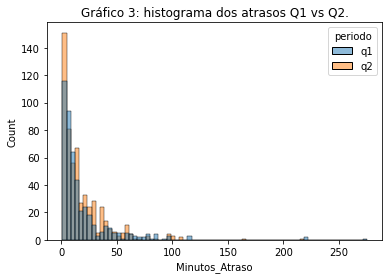

In [16]:
# Qual o comportamento dos atrasos em Q1 e Q2?
fig = sns.histplot(data=df_nps.loc[(df_nps['Minutos_Atraso'] > 0)], x='Minutos_Atraso', hue='periodo')
fig.set(title='Gráfico 3: histograma dos atrasos Q1 vs Q2.')
plt.show()

In [157]:
# Quais são os maiores atrasos?
df_nps.sort_values('Minutos_Atraso', ascending=False).head(5)

,Id,Data_Voo,Minutos_Atraso,Tempo_Voo,AirportLegs,Equipamento_Tipo,Nota_Principal,Nota_CheckinWeb,Nota_CheckinMobile,Nota_Comissarios,...,perfil_Nota_CheckinWeb,perfil_Nota_CheckinMobile,perfil_Nota_Comissarios,perfil_Nota_Entretenimento,perfil_Nota_Bagagem,periodo,mes,dummy_fds_feriado,list_airport,checkin
378,1813882,2022-01-23,275.0,60,VIX/CNF,Embraer,7,6.0,NaN,9.0,...,detrator,sem_avaliacao,promotor,neutro,sem_avaliacao,q1,2022-01-01,1,"[VIX, CNF]",6.0
10,1810488,2022-01-01,219.0,440,CGB/VCP/XAP,Embraer-A320,10,NaN,NaN,10.0,...,sem_avaliacao,sem_avaliacao,promotor,sem_avaliacao,promotor,q1,2022-01-01,1,"[CGB, VCP, XAP]",NaN
310,1810509,2022-01-18,219.0,215,SDU/VCP/XAP,Embraer,0,8.0,NaN,6.0,...,neutro,sem_avaliacao,detrator,neutro,sem_avaliacao,q1,2022-01-01,0,"[SDU, VCP, XAP]",8.0
2241,1770534,2022-05-19,216.0,80,FLN/GRU,Embraer,5,NaN,NaN,10.0,...,sem_avaliacao,sem_avaliacao,promotor,neutro,promotor,q2,2022-05-01,0,"[FLN, GRU]",NaN
1983,1767072,2022-05-04,163.0,1095,IMP/SLZ/CNF/GIG,Embraer,8,9.0,NaN,9.0,...,promotor,sem_avaliacao,promotor,promotor,sem_avaliacao,q2,2022-05-01,0,"[IMP, SLZ, CNF, GIG]",9.0


In [158]:
# Qual o comportamento dos atrasos em Q1?
print(f"Total vôos em Q1: {df_nps.loc[df_nps['periodo'] == 'q1'].shape[0]}")
display(df_nps.loc[(df_nps['periodo'] == 'q1') & (df_nps['Minutos_Atraso'] > 0)][['Minutos_Atraso']].describe().T)

print(f"Qtd atrasos até 14 minutos em Q1: {df_nps.loc[(df_nps['periodo'] == 'q1') & (df_nps['Minutos_Atraso'] <= 14)].shape[0]}\n")

print('Atrasos a partir de 15 minutos em Q1:')
display(df_nps.loc[(df_nps['periodo'] == 'q1') & (df_nps['Minutos_Atraso'] >= 15)][['Minutos_Atraso']].describe().T)

Total vôos em Q1: 1476


,count,mean,std,min,25%,50%,75%,max
Minutos_Atraso,466.0,18.819742,27.175054,1.0,5.0,10.0,21.0,275.0


Qtd atrasos até 14 minutos em Q1: 1307

Atrasos a partir de 15 minutos em Q1:


,count,mean,std,min,25%,50%,75%,max
Minutos_Atraso,169.0,40.710059,35.534088,15.0,20.0,28.0,47.0,275.0


In [156]:
# Qual o comportamento dos atrasos em Q2?
print(f"Total vôos em Q2: {df_nps.loc[df_nps['periodo'] == 'q2'].shape[0]}")
display(df_nps.loc[(df_nps['periodo'] == 'q2') & (df_nps['Minutos_Atraso'] > 0)][['Minutos_Atraso']].describe().T)

print(f"Qtd atrasos até 14 minutos em Q2: {df_nps.loc[(df_nps['periodo'] == 'q2') & (df_nps['Minutos_Atraso'] <= 14)].shape[0]}\n")

print('Atrasos a partir de 15 minutos em Q2:')
display(df_nps.loc[(df_nps['periodo'] == 'q2') & (df_nps['Minutos_Atraso'] >= 15)][['Minutos_Atraso']].describe().T)

Total vôos em Q2: 1394


,count,mean,std,min,25%,50%,75%,max
Minutos_Atraso,564.0,18.379433,21.763169,1.0,4.0,12.0,25.25,216.0


Qtd atrasos até 14 minutos em Q2: 1153

Atrasos a partir de 15 minutos em Q2:


,count,mean,std,min,25%,50%,75%,max
Minutos_Atraso,241.0,35.141079,24.409288,15.0,20.0,28.0,41.0,216.0


In [159]:
# Considerando apenas os vôos com atrasos a partir de 15 minutos, como estão seus perfis de promotores/neutros/detratores?


##### [ideia] Perfis de atraso
De todos os vôos, 1030 (aproximadamente 37%) registraram atrasos. Enquanto a metade dos atrasos foram de até 11 minutos, também houveram atrasos de 275 minutos. Essa variável é promissora na análise de NPS, dada a alta frequência de atrasos.

#### Duração de vôo

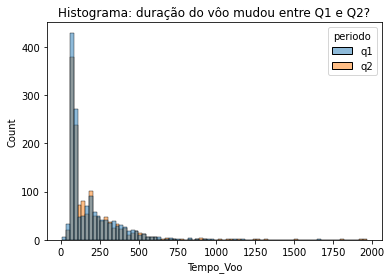

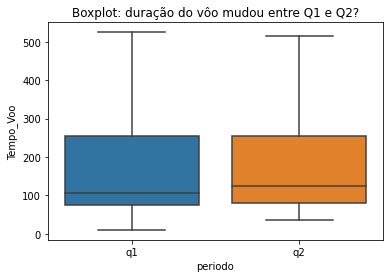

periodo Tempo_Voo                         
                min        mean median   max
0      q1        10  187.749322  105.0  1655
1      q2        35  198.366571  125.0  1965

In [60]:
# Qual comportamento do tempo de vôo?
fig = sns.histplot(data=df_nps, x='Tempo_Voo', hue='periodo')
fig.set(title='Histograma: duração do vôo mudou entre Q1 e Q2?')
plt.show()

fig = sns.boxplot(data=df_nps, x='periodo', y='Tempo_Voo', showfliers=False)
fig.set(title='Boxplot: duração do vôo mudou entre Q1 e Q2?')
plt.show()

df_nps.groupby(['periodo'], as_index=False).agg({'Tempo_Voo':['min', 'mean', 'median', 'max']})

##### [ideia] Vôos mais longos em Q2

In [21]:
# Existe vôo com duração negativa?
df_nps_raw.loc[df_nps_raw['Tempo_Voo'] <= 0]

# obs: verificação na base original (df_nps_raw), dado que na base processada esse caso já foi removido.

,Id,Data_Voo,Minutos_Atraso,Tempo_Voo,AirportLegs,Equipamento_Tipo,Nota_Principal,Nota_CheckinWeb,Nota_CheckinMobile,Nota_Comissarios,...,O processo de check in web funcionou corretamente?,O processo de check in web foi simples?,O processo de check in pelo celular foi simples?,O processo de check in pelo celular funcionou corretamente?,O sistema de entretenimento apresentou algum problema durante o voo?,Qual foi o problema?,Foi oferecido fone a bordo?,O tempo de espera pela bagagem no destino foi satisfatório?,Você ficou satisfeito com as condições de sua bagagem na devolução?,Você ficou satisfeito com o atendimento em caso de dano/extravio?
1745,1887425,2022-04-17 00:00:00,0.0,-790,JDO/PNZ/VCP/CWB/IGU,Embraer,10,NaN,NaN,10.0,...,NaN,NaN,NaN,NaN,Não,NaN,Não,Sim,Não,Não
2627,1905642,2022-06-12 00:00:00,NaN,0,FOR/SLZ,A320,10,10.0,NaN,10.0,...,Sim,Sim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Qual vôo tem duração de 10 minutos?
df_nps.loc[df_nps['Tempo_Voo'] == df_nps['Tempo_Voo'].min()]

,Id,Data_Voo,Minutos_Atraso,Tempo_Voo,AirportLegs,Equipamento_Tipo,Nota_Principal,Nota_CheckinWeb,Nota_CheckinMobile,Nota_Comissarios,...,validacao,perfil_Nota_Principal,perfil_Nota_CheckinWeb,perfil_Nota_CheckinMobile,perfil_Nota_Comissarios,perfil_Nota_Entretenimento,perfil_Nota_Bagagem,periodo,mes,dummy_fds_feriado
1312,1853584,2022-03-22,0.0,10,FEN/REC,Embraer,10,NaN,10.0,10.0,...,ok,promotor,sem_avaliacao,promotor,promotor,promotor,promotor,q1,2022-03-01,0


##### [risco] Qualidade dado
De maneira geral, o comportamento da duração dos vôos é heterogênea, variando de 10 a 1965 minutos. Essa amostra, entretanto, parece conter problemas: a menor duração válida é de 10 minutos, partindo de Fernando de Noronha para Recife. Uma breve pesquisa no site da Azul indica que esse trecho é coberto em aproximadamente 95 minuto, que é muito mais crível que os 10 minutos presentes na amostra. Apesar de promissora, esse dado precisa ser levado com parcimônia.

[Text(0.5, 1.0, 'Vôos longos tendem a ter mais clientes insatisfeitos?')]

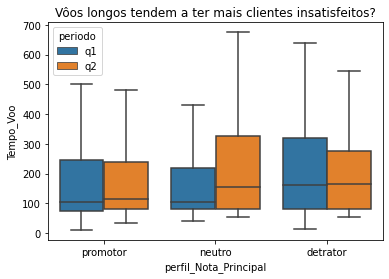

In [55]:
# Será que a duração de vôo influencia na satisfação do cliente?
fig = sns.boxplot(data=df_nps, x='perfil_Nota_Principal', y='Tempo_Voo', hue='periodo', showfliers=False)
fig.set(title='Vôos longos tendem a ter mais clientes insatisfeitos?')

##### [ideia] vôos longos piora NPS
Vôos mais longos são mais cansativos e tendem a deixar clientes menos satisfeitos.

#### Aeroporto

In [62]:
# Qual é o comportamento dos Aeroportos?
df_nps['list_airport'] = df_nps['AirportLegs'].str.split('/')
df_nps['list_airport'].value_counts()[:4]

[SSA, VCP]    29
[VCP, SDU]    29
[CNF, SDU]    27
[CWB, IGU]    25
Name: list_airport, dtype: int64

In [63]:
# Quais são os aerportos mais visitados pela Azul?
dict_airport = {}
for i in df_nps['list_airport']:
    for j in i:
        if j not in dict_airport.keys():
            dict_airport[j] = 1
        else:
            dict_airport[j] += 1

ranking_airports = sorted(dict_airport.items(), key=lambda x:x[1], reverse=True)
print(f"Top 5: {ranking_airports[:5]}")
print(f"Bottom 5: {ranking_airports[-5:]}")

Top 5: [('VCP', 1045), ('CNF', 725), ('REC', 471), ('GRU', 373), ('POA', 372)]
Bottom 5: [('FEC', 2), ('LAJ', 1), ('CFB', 1), ('VAL', 1), ('PHB', 1)]


##### [ideia] aeroporto com melhor estrutura

Os top 5 aeroportos mais visitados são:
- VRP (ViraCopos, SP): 1045
- CNF (Confins, MG): 725
- REC (Recife/Guararapes, RE): 471
- GRU (Guarulhos, SP): 373
- POA (Porto Alegre, RS): 372

Já os top 5 aeroportos menos visitados são:
- FEC (Feira de Santana, BA): 1
- LAJ (Lages, SC): 1
- CFB (Cabo Frio, RJ): 1
- VAL (Val de Cans, PA): 1
- PHB (Parnaíba, PI): 1

Coerentemente, a Azul tem maior presença em territórios próximos às sedes de Campinas, Belo Horizonte e Recife. Além disso, é possível que a alta frequência de vôos esteja correlacionada com o NPS, dado que se a Azul faz muitos vôos para determinado aeroporto, faz sentido alocar maior parcela de recursos, melhorando o serviço em geral. 

In [95]:
df_nps['perfil_Nota_Principal'].value_counts()
a = {}
a['b']={'c':1, 'd':2}
#a['b']['c'] += 10
'b' not in a.keys()
'REC' not in dict_airport_nps

True

In [117]:
# Quais são os aeroportos que tiverma mais notas promotoras/neutras/detratoras?
dict_airport_nps_q1 = {}
dict_airport_nps_q2 = {}

for index, row in df_nps.iterrows():
    if (row['periodo'] == 'q1'):
        for i in row['list_airport']:
            if (i not in dict_airport_nps_q1.keys()):
                dict_airport_nps_q1[i] = {'promotor': 0, 'neutro': 0, 'detrator':0, 'total_q1':0}       
            dict_airport_nps_q1[i][row['perfil_Nota_Principal']] += 1
            dict_airport_nps_q1[i]['total_q1'] += 1
    else:
        for i in row['list_airport']:
            if (i not in dict_airport_nps_q2.keys()):
                dict_airport_nps_q2[i] = {'promotor': 0, 'neutro': 0, 'detrator':0, 'total_q2':0}       
            dict_airport_nps_q2[i][row['perfil_Nota_Principal']] += 1
            dict_airport_nps_q2[i]['total_q2'] += 1        

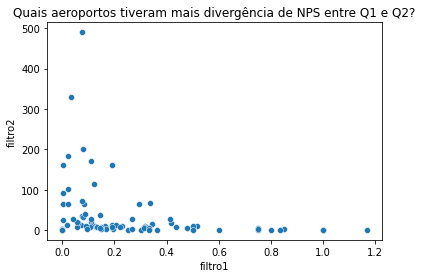

In [136]:
# Unificar os dados organizados em dicionários acima e compará-los.
df_nps_air_q1 = pd.DataFrame(dict_airport_nps_q1).T.reset_index()
df_nps_air_q1['nps_q1'] = (df_nps_air_q1['promotor'] - df_nps_air_q1['detrator'])/df_nps_air_q1['total_q1']

df_nps_air_q2 = pd.DataFrame(dict_airport_nps_q2).T.reset_index()
df_nps_air_q2['nps_q2'] = (df_nps_air_q2['promotor'] - df_nps_air_q2['detrator'])/df_nps_air_q2['total_q2']

df = pd.merge(df_nps_air_q1, df_nps_air_q2[['index', 'total_q2', 'nps_q2']], on='index', how='outer')

# Criar filtros que indiquem quais casos são mais divergentes.
df['filtro1'] = np.abs(df['nps_q1'] - df['nps_q2'])
df['filtro2'] = df[['total_q1', 'total_q2']].min(axis=1)

fig = sns.scatterplot(data=df, x='filtro1', y='filtro2')
fig.set(title='Quais aeroportos tiveram mais divergência de NPS entre Q1 e Q2?')
plt.show()

In [194]:
# Qual é a distribuição de vôos por aeroporto?
df[['filtro2']].describe().round(2)

,filtro2
count,97.00
mean,32.25
std,70.41
min,1.00
25%,3.00
50%,8.00
75%,26.00
max,490.00


In [196]:
# Qual aeroporto que apresentou relevantes número de vôos e variação de NPS?
df.loc[(df['filtro1'] >= 0.10) & (df['filtro2'] >= 20)].sort_values('filtro1', ascending=False)

,index,promotor,neutro,detrator,total_q1,nps_q1,total_q2,nps_q2,filtro1,filtro2
26,CGR,31.0,4.0,2.0,37.0,0.783784,27.0,0.370370,0.413413,27.0
33,BEL,57.0,13.0,7.0,77.0,0.649351,67.0,0.313433,0.335918,67.0
32,FOR,57.0,3.0,5.0,65.0,0.800000,93.0,0.505376,0.294624,65.0
36,THE,22.0,4.0,3.0,29.0,0.655172,36.0,0.388889,0.266284,29.0
28,SDU,149.0,20.0,17.0,186.0,0.709677,162.0,0.518519,0.191159,162.0
37,GIG,33.0,6.0,11.0,50.0,0.440000,37.0,0.297297,0.142703,37.0
14,CGB,108.0,13.0,11.0,132.0,0.734848,114.0,0.614035,0.120813,114.0
23,CWB,142.0,28.0,24.0,194.0,0.608247,171.0,0.719298,0.111051,171.0
31,RAO,20.0,3.0,6.0,29.0,0.482759,27.0,0.592593,0.109834,27.0
22,UDI,22.0,5.0,3.0,30.0,0.633333,21.0,0.523810,0.109524,21.0


In [146]:
# Juntando as hipóteses de aeroporto + avião, será que em SDU houveram muitos vôos com aviões da série A320?
df_nps.loc[(df_nps['AirportLegs'].str.contains('SDU'))].groupby(['periodo', 'Equipamento_Tipo'], as_index=False).agg({'Id':'count'})

,periodo,Equipamento_Tipo,Id
0,q1,ATR,5
1,q1,Embraer,149
2,q1,Embraer-A320,13
3,q1,Embraer-A330,1
4,q1,Embraer-ATR,17
5,q1,MISTO,1
6,q2,ATR,9
7,q2,Embraer,128
8,q2,Embraer-A320,10
9,q2,Embraer-ATR,15


In [210]:
# Lista de aeroportos que tiveram as maiores pioras de NPS.
list_airport_bad = df.loc[(df[['total_q1','total_q2']].min(axis=1) >= 20) & (df['nps_q1'] - df['nps_q2'] > 0.05)].sort_values('filtro1', ascending=False).head(5)['index'].tolist()
list_airport_bad

['CGR', 'BEL', 'FOR', 'THE', 'SDU']

##### [ideia] Top 5 aeroportos com quedas de NPS
Aconteceu algo com os vôos com destino/origem em Santos Drummon, dada seu baixo NPS no Q2.

0    2137
1     733
Name: dummy_aeroporto_queda_nps, dtype: int64

<AxesSubplot:xlabel='dummy_aeroporto_queda_nps', ylabel='Minutos_Atraso'>

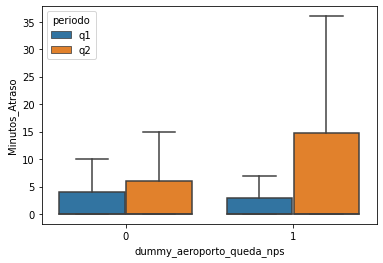

In [203]:
# Comparando os aeroportos (a) com maior queda de NPS e (b) outros, será que observamos diferença nos atrasos?
list_airport_bad = df.loc[(df[['total_q1','total_q2']].min(axis=1) >= 20) & (df['nps_q1'] - df['nps_q2'] > 0.04)].sort_values('filtro1', ascending=False).head(5)['index'].tolist()

df_nps['dummy_aeroporto_queda_nps'] = np.where(df_nps['AirportLegs'].str.contains('|'.join(list_airport_bad)), 1, 0)
display(df_nps['dummy_aeroporto_queda_nps'].value_counts())

sns.boxplot(data=df_nps, x='dummy_aeroporto_queda_nps', y='Minutos_Atraso', hue='periodo', showfliers=False)

#### Equipamento

In [25]:
# Quais são as principais aeronaves usadas?
df_nps['Equipamento_Tipo'].value_counts()

Embraer         1635
A320             404
ATR              250
Embraer-ATR      242
Embraer-A320     207
ATR-A320          94
MISTO             18
A330              11
Embraer-A330       6
ATR-A330           3
Name: Equipamento_Tipo, dtype: int64

In [27]:
azul.compare_nps_categorical(df_nps, 'perfil_Nota_Principal', 'Equipamento_Tipo')

perfil_Nota_Principal,Equipamento_Tipo,total_q1,total_q2,nps_q1,nps_q2
0,A320,176,228.0,0.64,0.48
1,A330,11,NaN,0.73,NaN
2,ATR,134,116.0,0.56,0.52
3,ATR-A320,50,44.0,0.34,0.55
4,ATR-A330,3,NaN,0.67,NaN
5,Embraer,855,780.0,0.66,0.64
6,Embraer-A320,110,97.0,0.55,0.49
7,Embraer-A330,6,NaN,0.67,NaN
8,Embraer-ATR,125,117.0,0.55,0.48
9,MISTO,6,12.0,0.17,0.00


##### [ideia] aviões A320 e ATR-A320
Por que temos diferença de NPS em aviões A320 e ATR-320?

### NPS

#### NPS Principal

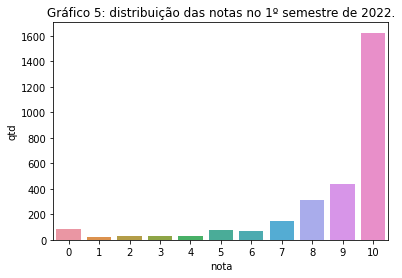

,count,mean,std,min,25%,50%,75%,max
Nota_Principal,2870.0,8.642857,2.36072,0.0,8.0,10.0,10.0,10.0


In [28]:
# NPS em geral.
df_plot = df_nps['Nota_Principal'].value_counts().reset_index().sort_values('index', ascending=False)
df_plot.columns = ['nota', 'qtd']

fig = sns.barplot(data=df_plot, x='nota', y='qtd')
fig.set(title='Gráfico 5: distribuição das notas no 1º semestre de 2022.')
plt.show()

df_nps['Nota_Principal'].describe().to_frame().T

In [29]:
# Temos nota principal em todas os vôos?
print(f"Quantidade de notas principais: {df_nps.loc[df_nps['Nota_Principal'].notnull()].shape[0]}")

Quantidade de notas principais: 2870


perfil_Nota_Principal,mes,detrator,neutro,promotor,total,nps
0,2022-01-01,65,76,400,541,0.619224
1,2022-02-01,47,64,294,405,0.609877
2,2022-03-01,62,76,392,530,0.622642
3,2022-04-01,50,84,327,461,0.600868
4,2022-05-01,68,87,367,522,0.572797
5,2022-06-01,59,70,282,411,0.542579


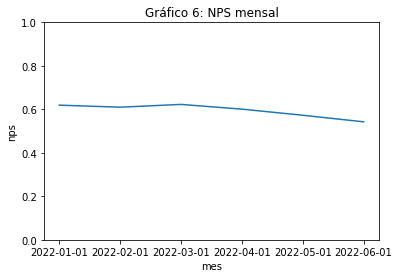

In [30]:
# Tabela contendo o nps calculado manualmente.
df_nps_mes = pd.pivot_table(data=df_nps, values='Id', index='mes', columns='perfil_Nota_Principal', aggfunc='count', margins=True, margins_name='total').reset_index(drop=False).iloc[:-1, :]
df_nps_mes['nps'] = (df_nps_mes['promotor'] - df_nps_mes['detrator'])/df_nps_mes['total']
display(df_nps_mes)

fig = sns.lineplot(data=df_nps_mes, x='mes', y='nps')
fig.set(title='Gráfico 6: NPS mensal', ylim=(0,1))
plt.show()

##### [correção] NPS sem inconsistências

As notas de NPS não batem na vírgula com os valores apresentados no Excel pois os casos com inconsistências foram desconsideradas. Apesar disso, o comportamento temporal de crescimentos e quedas se manteve.

![nps original](nps.PNG)

Index(['Nota_Principal', 'Nota_CheckinWeb', 'Nota_CheckinMobile',
       'Nota_Comissarios', 'Nota_Entretenimento', 'Nota_Bagagem'],
      dtype='object')

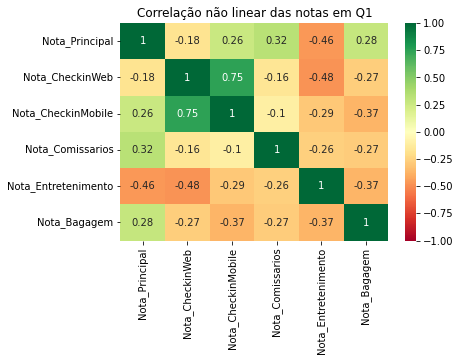

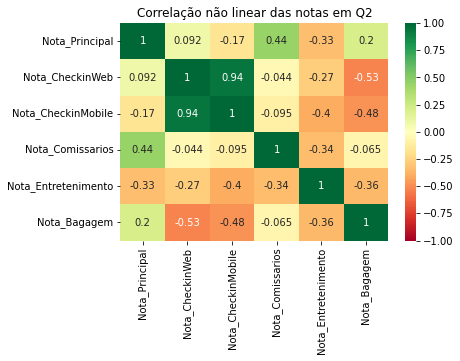

In [48]:
# Como as notas de cada avaliação se cruzam?
display(list_notas)

# Q1
fig = sns.heatmap(df_nps.loc[df_nps['periodo'] == 'q1'][list_notas].corr().corr(method='pearson'), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)
fig.set(title='Correlação não linear das notas em Q1')
plt.show()

# Q2
fig = sns.heatmap(df_nps.loc[df_nps['periodo'] == 'q2'][list_notas].corr().corr(method='pearson'), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)
fig.set(title='Correlação não linear das notas em Q2')
plt.show()

#### NPS Checkin

In [32]:
# Será que alguém deu nota ambos para o Checkin Web e Mobile?
print(f"Quantas pessoas deram nota ambos para o Checkin Web e Mobile: {df_nps.loc[(df_nps['Nota_CheckinWeb'].notnull()) & (df_nps['Nota_CheckinMobile'].notnull())].shape[0]}")

# obs: é possível supor que a pessoa se enganou e acabou preenchendo duas vezes. Nesses casos, consdervadoramente, será considerada a menor nota.

Quantas pessoas deram nota ambos para o Checkin Web e Mobile: 2


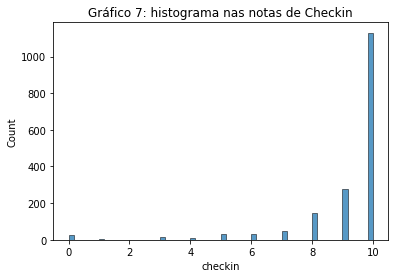

,NaN,10.0,9.0,8.0,7.0,5.0,6.0,0.0,3.0,4.0,1.0,2.0
checkin,1148,1130,276,144,48,33,32,26,14,11,7,1


In [33]:
# Unificando as notas de Checkin Web e Mobile
df_nps['checkin'] = np.where(df_nps['Nota_CheckinMobile'].isnull(), df_nps['Nota_CheckinWeb'], df_nps['Nota_CheckinMobile'])

# Aplicando a regra da menornota.
for index, row in df_nps.iterrows():
    if (pd.isnull(row['Nota_CheckinWeb'])) & (pd.isnull(row['Nota_CheckinMobile'])):
        valor = np.min([row['Nota_CheckinWeb'], row['Nota_CheckinMobile']])
        df_nps.at[index, 'checkin'] = valor

fig = sns.histplot(df_nps['checkin'])
fig.set(title='Gráfico 7: histograma nas notas de Checkin')
plt.show()

df_nps['checkin'].value_counts(dropna=False).to_frame().T

In [34]:
# Quem deu nota do Checkn Web também respondeu sobre simplicidade e funcionamento?
print('Quem respondeu nota, mas não as outras perguntas')
display(df_nps.loc[
    (df_nps['Nota_CheckinWeb'].notnull()) &\
    (df_nps['O processo de check in web funcionou corretamente?'].isnull()) &\
    (df_nps['O processo de check in web foi simples?'].isnull())
][['Nota_CheckinWeb', 'O processo de check in web funcionou corretamente?', 'O processo de check in web foi simples?']])

print('Quem não respondeu nota, mas sim as outras perguntas')
display(df_nps.loc[
    (df_nps['Nota_CheckinWeb'].isnull()) &\
    (df_nps['O processo de check in web funcionou corretamente?'].notnull()) &\
    (df_nps['O processo de check in web foi simples?'].notnull())
][['Nota_CheckinWeb', 'O processo de check in web funcionou corretamente?', 'O processo de check in web foi simples?']]
)

Quem respondeu nota, mas não as outras perguntas


,Nota_CheckinWeb,O processo de check in web funcionou corretamente?,O processo de check in web foi simples?
105,9.0,NaN,NaN
981,10.0,NaN,NaN
1263,9.0,NaN,NaN
2469,10.0,NaN,NaN


Quem não respondeu nota, mas sim as outras perguntas


,Nota_CheckinWeb,O processo de check in web funcionou corretamente?,O processo de check in web foi simples?


In [35]:
# Quem deu nota do Checkn Mobile também respondeu sobre simplicidade e funcionamento?
print('Quem respondeu nota, mas não as outras perguntas')
display(df_nps.loc[
    (df_nps['Nota_CheckinMobile'].notnull()) &\
    (df_nps['O processo de check in pelo celular funcionou corretamente?'].isnull()) &\
    (df_nps['O processo de check in pelo celular foi simples?'].isnull())
][['Nota_CheckinMobile', 'O processo de check in pelo celular funcionou corretamente?', 'O processo de check in pelo celular foi simples?']])

print('Quem não respondeu nota, mas sim as outras perguntas')
display(df_nps.loc[
    (df_nps['Nota_CheckinMobile'].isnull()) &\
    (df_nps['O processo de check in pelo celular funcionou corretamente?'].notnull()) &\
    (df_nps['O processo de check in pelo celular foi simples?'].notnull())
][['Nota_CheckinMobile', 'O processo de check in pelo celular funcionou corretamente?', 'O processo de check in pelo celular foi simples?']]
)

Quem respondeu nota, mas não as outras perguntas


,Nota_CheckinMobile,O processo de check in pelo celular funcionou corretamente?,O processo de check in pelo celular foi simples?
842,9.0,NaN,NaN
843,10.0,NaN,NaN
889,10.0,NaN,NaN
1315,0.0,NaN,NaN
2496,9.0,NaN,NaN
2810,6.0,NaN,NaN


Quem não respondeu nota, mas sim as outras perguntas


,Nota_CheckinMobile,O processo de check in pelo celular funcionou corretamente?,O processo de check in pelo celular foi simples?


##### Aprendizado

Temos praticamente 55% de respondentes sobre o Checkin, sendo que praticamente todos também responderam as perguntas sobre o funcionamento e a simplicidade de uso do Checkin. 

#### Correlação de NPS

In [36]:
# Como estão as notas de forma geral?
df_nps[['Nota_Principal', 'checkin', 'Nota_Comissarios', 'Nota_Entretenimento', 'Nota_Bagagem']].describe().round(2)

,Nota_Principal,checkin,Nota_Comissarios,Nota_Entretenimento,Nota_Bagagem
count,2870.00,1722.00,2738.00,1377.00,1260.00
mean,8.64,9.13,9.32,8.76,8.17
std,2.36,1.81,1.43,1.92,2.51
min,0.00,0.00,0.00,0.00,0.00
25%,8.00,9.00,9.00,8.00,8.00
50%,10.00,10.00,10.00,10.00,9.00
75%,10.00,10.00,10.00,10.00,10.00
max,10.00,10.00,10.00,10.00,10.00


In [37]:
# Unificar os NPS de cada categoria
df_checkin = calcular_nps(df_nps, 'checkin')
df_comissar = calcular_nps(df_nps, 'Nota_Comissarios')
df_entrete = calcular_nps(df_nps, 'Nota_Entretenimento')
df_bag = calcular_nps(df_nps, 'Nota_Bagagem')

df_nps_merge = df_nps_mes
df_nps_merge = pd.merge(df_nps_merge[['mes', 'nps']], df_checkin[['mes', 'nps']].rename(columns={'nps':'checkin'}), on='mes', how='left')
df_nps_merge = pd.merge(df_nps_merge[['mes', 'nps', 'checkin']], df_comissar[['mes', 'nps']].rename(columns={'nps':'comissario'}), on='mes', how='left')
df_nps_merge = pd.merge(df_nps_merge[['mes', 'nps', 'checkin', 'comissario']], df_entrete[['mes', 'nps']].rename(columns={'nps':'entretenimento'}), on='mes', how='left')
df_nps_merge = pd.merge(df_nps_merge[['mes', 'nps', 'checkin', 'comissario', 'entretenimento']], df_bag[['mes', 'nps']].rename(columns={'nps':'bagagem'}), on='mes', how='left')

df_nps_merge

NameError: name 'calcular_nps' is not defined

In [ ]:
df_nps_merge['periodo'] = np.where(df_nps_merge['mes'] >= '2022-04-01', 'q2', 'q1')

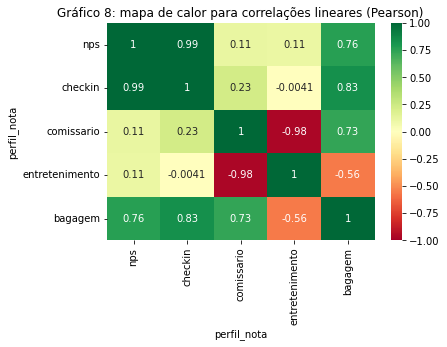

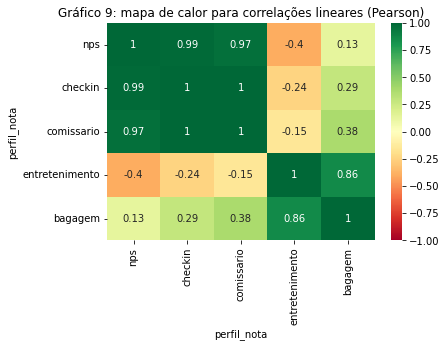

In [ ]:
# Correlação linear das notas entre períodos
fig = sns.heatmap(df_nps_merge.loc[df_nps_merge['periodo'] == 'q1'].corr(method='pearson'), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)
fig.set(title='Gráfico 8: mapa de calor para correlações lineares (Pearson)')
plt.show()

fig = sns.heatmap(df_nps_merge.loc[df_nps_merge['periodo'] == 'q2'].corr(method='pearson'), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)
fig.set(title='Gráfico 9: mapa de calor para correlações lineares (Pearson)')
plt.show()

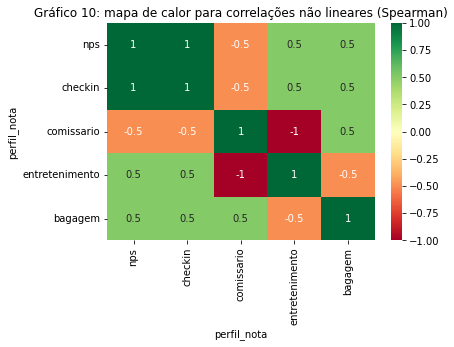

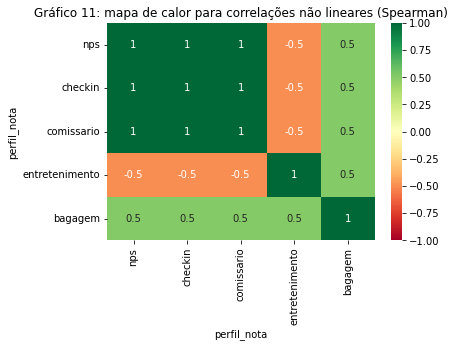

In [ ]:
# Correlação não linear das notas entre períodos
fig = sns.heatmap(df_nps_merge.loc[df_nps_merge['periodo'] == 'q1'].corr(method='spearman'), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)
fig.set(title='Gráfico 10: mapa de calor para correlações não lineares (Spearman)')
plt.show()

fig = sns.heatmap(df_nps_merge.loc[df_nps_merge['periodo'] == 'q2'].corr(method='spearman'), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)
fig.set(title='Gráfico 11: mapa de calor para correlações não lineares (Spearman)')
plt.show()

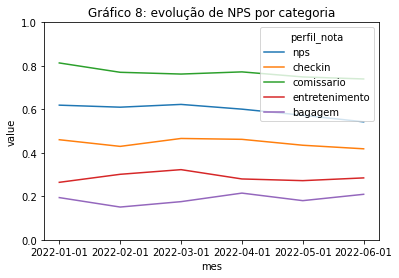

In [ ]:
# Plot do NPS de todas as categorias.
fig = sns.lineplot(data=pd.melt(df_nps_merge, id_vars='mes', value_vars=['nps', 'checkin', 'comissario', 'entretenimento', 'bagagem']), x='mes', y='value', hue='perfil_nota')
fig.set(title='Gráfico 8: evolução de NPS por categoria', ylim=(0,1))
plt.show()

##### Aprendizado

A correlação de NPS vs comissário e NPS vs entretenimento mudou de Q1 a Q2. Esse pode ser um indício de onde começar a explorar as mudanças que ocorridas.

#### NPS Comissário

In [ ]:
# Quantas notas temos?
print(f"Temos {df_nps.loc[df_nps['Nota_Comissarios'].notnull()].shape[0]} de {df_nps.shape[0]} notas de comissários.")

Temos 2738 de 2870 notas de comissários.


In [ ]:
# Qual a taxa de respostas por mês?
df_tx = df_nps.groupby('mes', as_index=False).agg({'Id':'count', 'Nota_Comissarios':'count'})
df_tx['tx_resposta'] = round(df_tx['Nota_Comissarios'] / df_tx['Id'] * 100, 1)

display(df_tx)

total_q1 = df_tx.loc[df_tx['mes'] <='2022-03-01', 'Id'].sum()
nota_q1 = df_tx.loc[df_tx['mes'] <='2022-03-01', 'Nota_Comissarios'].sum()
total_q2 = df_tx.loc[df_tx['mes'] > '2022-03-01', 'Id'].sum()
nota_q2 = df_tx.loc[df_tx['mes'] > '2022-03-01', 'Nota_Comissarios'].sum()

print(f"""
Em Q1 tivemos {nota_q1} de {total_q1} respostas ({round(nota_q1/total_q1 * 100, 1)}%).
Em Q2 tivemos {nota_q2} de {total_q2} respostas ({round(nota_q2/total_q2 * 100, 1)}%).
""")

,mes,Id,Nota_Comissarios,tx_resposta
0,2022-01-01,541,541,100.0
1,2022-02-01,405,382,94.3
2,2022-03-01,530,497,93.8
3,2022-04-01,461,440,95.4
4,2022-05-01,522,491,94.1
5,2022-06-01,411,387,94.2



Em Q1 tivemos 1420 de 1476 respostas (96.2%).
Em Q2 tivemos 1318 de 1394 respostas (94.5%).



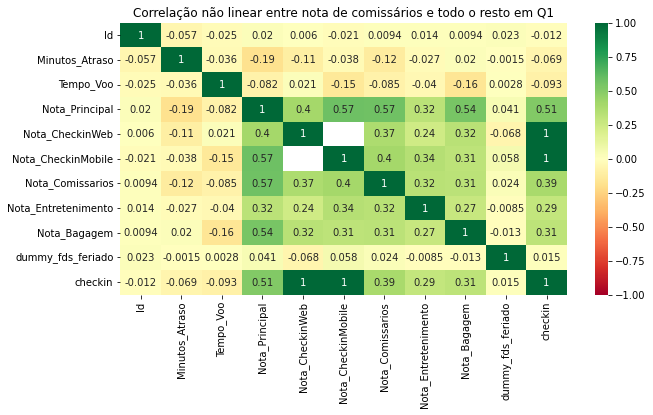

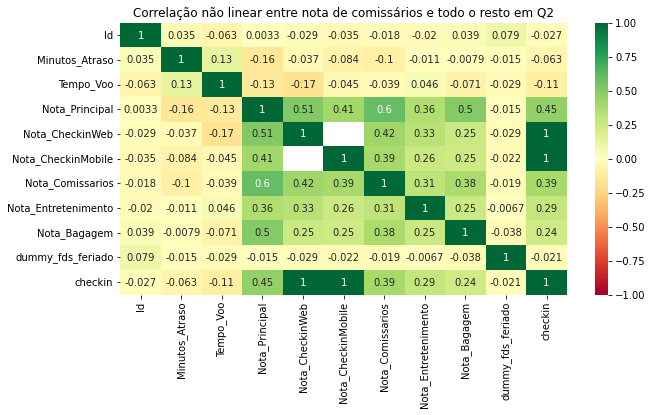

In [ ]:
# O NPS Comissário apresentou mudou a maneira com que se relaciona com outras variáveis?
df_q1 = df_nps.loc[df_nps['Data_Voo'] < '2022-04-01']
df_q2 = df_nps.loc[df_nps['Data_Voo'] >= '2022-04-01']

plt.figure(figsize=(10,5))
fig = sns.heatmap(df_q1.corr(method='pearson'), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)
fig.set(title='Correlação não linear entre nota de comissários e todo o resto em Q1')
plt.show()

plt.figure(figsize=(10,5))
fig = sns.heatmap(df_q2.corr(method='pearson'), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)
fig.set(title='Correlação não linear entre nota de comissários e todo o resto em Q2')
plt.show()

In [ ]:
# Existe alguma relação entre nota de comissários e variáveis categóricas?
df_q1 = pd.pivot_table(data=df_nps_q1, values='Id', index='Equipamento_Tipo', columns='perfil_Nota_Comissarios', aggfunc='count', margins=True, margins_name='total', fill_value=0).iloc[:-1].reset_index()
df_q1['nps'] = (df_q1['promotor'] - df_q1['detrator'])/df_q1['total']
df_q1.rename(columns={'total':'total_q1', 'nps':'nps_q1'}, inplace=True)

df_q2 = pd.pivot_table(data=df_nps_q2, values='Id', index='Equipamento_Tipo', columns='perfil_Nota_Comissarios', aggfunc='count', margins=True, margins_name='total', fill_value=0).iloc[:-1].reset_index()
df_q2['nps'] = (df_q2['promotor'] - df_q2['detrator'])/df_q2['total']
df_q2.rename(columns={'total':'total_q2', 'nps':'nps_q2'}, inplace=True)

pd.merge(df_q1, df_q2[['Equipamento_Tipo', 'total_q2', 'nps_q2']], on='Equipamento_Tipo', how='left').fillna(0).round(2)

perfil_Nota_Comissarios,Equipamento_Tipo,detrator,neutro,promotor,sem_avaliacao,total_q1,nps_q1,total_q2,nps_q2
0,A320,1,30,135,10,176,0.76,228.0,0.69
1,A330,0,1,9,1,11,0.82,0.0,0.00
2,ATR,5,12,110,7,134,0.78,116.0,0.73
3,ATR-A320,7,7,34,2,50,0.54,44.0,0.73
4,ATR-A330,0,0,3,0,3,1.00,0.0,0.00
5,Embraer,24,94,704,33,855,0.80,780.0,0.78
6,Embraer-A320,8,10,90,2,110,0.75,97.0,0.78
7,Embraer-A330,0,0,6,0,6,1.00,0.0,0.00
8,Embraer-ATR,2,14,108,1,125,0.85,117.0,0.73
9,MISTO,1,0,5,0,6,0.67,12.0,0.75


##### Aprendizado

Ao comparar os períodos, a taxa de respostas de nota de comissários caiu de 96,2% para 94,5%. A diferença parece ser pequena, sendo improvável que essa seja um fator relevante para a mudança de comportamento do NPS Comissários.
- a correlação não linear entre as variáveis numéricas não apresentou grandes diferentes entre os períodos.

#### NPS Entretenimento

## Análise de hipóteses

- Atrasos diminuem a satisfação.
- Atrasos pequenos em vôos longos são indiferentes ao NPS.
- NPS em vôos no fim de semana/feriado são maiores. 
- Dado tudo o mais constante, quanto maior a duração do vôo menor o NPS.
- Aeroportos com menos circulação de vôos tem menor NPS.
- Vôos com muitas conexões têm menor NPS.
- Vôos com baixa nota de comissários também apresentam mais atrasos.
- Entretenimento tem pouca influência em NPS
- Bagagem é raro, mas quando acontece, é o maior detrator de NPS.
- Onde há mais problemas de Checkin também há maiores atrasos.

### Conjunto: atrasos

##### H1. "Atrasos estão associados a insatisfação."
Hipótese: atrasos estão associados a NPS baixos.

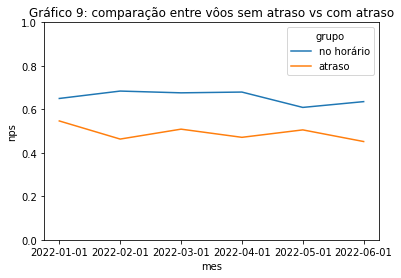

In [ ]:
# Formulação mais básica da hipótese.
amostra1 = df_nps.loc[df_nps['Minutos_Atraso'] == 0]
amostra2 = df_nps.loc[df_nps['Minutos_Atraso'] > 0]

df1 = calcular_nps(amostra1, 'Nota_Principal')
df1['grupo'] = 'no horário'

df2 = calcular_nps(amostra2, 'Nota_Principal')
df2['grupo'] = 'atraso'

df_plot = pd.concat([df1, df2], axis=0, ignore_index=True)

fig = sns.lineplot(data=df_plot, x='mes', y='nps', hue='grupo')
fig.set(title='Gráfico 9: comparação entre vôos sem atraso vs com atraso', ylim=(0,1))
plt.show()

Insight

O gráfico acima mostra o NPS consistentemente superior em vôos sem atraso, apontando a relevância da variável para o NPS.

##### H2. "Pequenos atrasos são toleráveis."
Hipótese: atrasos de até 14 minutos não impactam NPS

In [ ]:
# Primeiro verificaremos se é possível agrupar tipos de atraso (ex: pequeno atraso, etc)
df_nps.loc[df_nps['Minutos_Atraso'] > 0, 'Minutos_Atraso'].describe(percentiles=np.arange(0, 10, 1)/10).to_frame().T

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
Minutos_Atraso,1030.0,18.578641,24.349678,1.0,1.0,2.0,3.0,5.0,8.0,11.0,14.0,19.3,28.0,44.0,275.0


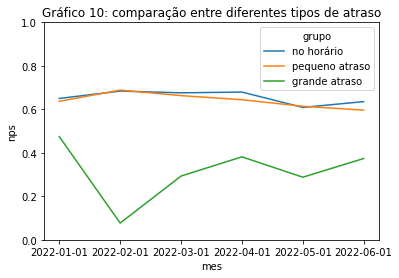

In [ ]:
# Classificando o tipo de atraso dado uma tolerância pré estabelecida.
tolerancia = 14

amostra1 = df_nps.loc[df_nps['Minutos_Atraso'] == 0]
amostra2 = df_nps.loc[df_nps['Minutos_Atraso'].between(0, tolerancia)]
amostra3 = df_nps.loc[df_nps['Minutos_Atraso'] > tolerancia]

df1 = calcular_nps(amostra1, 'Nota_Principal')
df1['grupo'] = 'no horário'

df2 = calcular_nps(amostra2, 'Nota_Principal')
df2['grupo'] = 'pequeno atraso'

df3 = calcular_nps(amostra3, 'Nota_Principal')
df3['grupo'] = 'grande atraso'

df_plot = pd.concat([df1, df2], axis=0, ignore_index=True)
df_plot = pd.concat([df_plot, df3], axis=0, ignore_index=True)

fig = sns.lineplot(data=df_plot, x='mes', y='nps', hue='grupo')
fig.set(title='Gráfico 10: comparação entre diferentes tipos de atraso', ylim=(0,1))
plt.show()

##### Insight
A comparação de NPS de vôos (a) sem atraso, (b) com atraso de até 15 minutos e (c) com atraso superior a 15 minutos, observamos que os dois primeiros grupos apresentaram NPS semelhante. Isso indica que, apesar do atraso ser algo relevante ao NPS, o público foi tolerante em relação a pequenos atrasos.

##### H3. "Há maior probabilidade de atrasos em vôos longos."
Hipótese: a correlação entre atrasos e vôos longos é relevante.

In [ ]:
# Correlação linear entre tempo de vôo vs atraso.
print('Correlação linear:')
display(df_nps[['Tempo_Voo', 'Minutos_Atraso']].corr(method='pearson'))

print('Correlação não-linear:')
display(df_nps[['Tempo_Voo', 'Minutos_Atraso']].corr(method='spearman'))

Correlação linear:


,Tempo_Voo,Minutos_Atraso
Tempo_Voo,1.000000,0.050947
Minutos_Atraso,0.050947,1.000000


Correlação não-linear:


,Tempo_Voo,Minutos_Atraso
Tempo_Voo,1.000000,0.073554
Minutos_Atraso,0.073554,1.000000


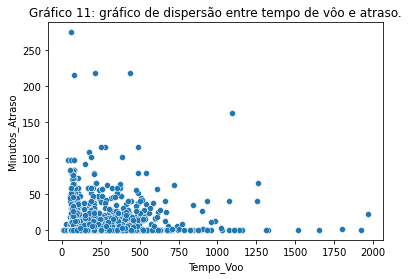

In [ ]:
fig = sns.scatterplot(data=df_nps, x='Tempo_Voo', y='Minutos_Atraso')
fig.set(title='Gráfico 11: gráfico de dispersão entre tempo de vôo e atraso.')
plt.show()

##### Insight
A correlação fraca entre tempo de vôo e minutos de atraso é evidência contrária a hipótese.



##### H4. "Clientes em fim de semana/feriado estão mais satisfeitos."
Hipótese: Vôos em fim de semana/feriado tem melhores NPS.

In [ ]:
# Quantas df_nps

##### H5. "Baixa performance de comissários estão associados a atrasos."
Hipótese: a correlação entre NPS Comissários e atraso é relevante em Q2.

In [ ]:
# Qual é a correlação entre as notas de comissários e atraso no geral?
df_nps[['Minutos_Atraso', 'Nota_Comissarios']].corr()

,Minutos_Atraso,Nota_Comissarios
Minutos_Atraso,1.00000,-0.10961
Nota_Comissarios,-0.10961,1.00000


Nota_Comissarios                       
                          min      mean median   max
tp_atraso                                           
muito_atraso              0.0  8.948187   10.0  10.0
pouco_atraso              0.0  9.409475   10.0  10.0
sem_atraso                0.0  9.375923   10.0  10.0

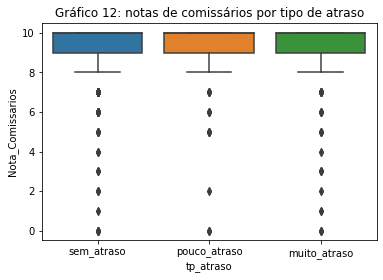

In [ ]:
# Considerando vôos (a) sem atraso, (b) atraso até 14 minutos e (c) atraso a partir de 15 minutos, avaliar as notas.
df_nps['tp_atraso'] = np.select(
    [
        df_nps['Minutos_Atraso'] == 0,
        df_nps['Minutos_Atraso'].between(0, 14),
        df_nps['Minutos_Atraso'] >= 15,
    ],['sem_atraso', 'pouco_atraso', 'muito_atraso'], '?'
)

fig = sns.boxplot(data=df_nps, x='tp_atraso', y='Nota_Comissarios')
fig.set(title='Gráfico 12: notas de comissários por tipo de atraso')

df_nps.groupby('tp_atraso').agg({'Nota_Comissarios':['min', 'mean', 'median', 'max']})

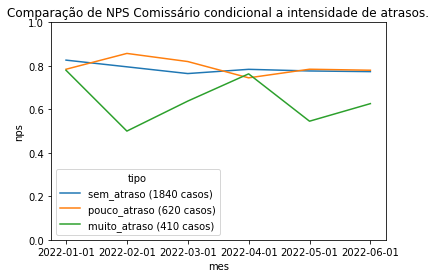

In [ ]:
# Cálculo do NPS Comissários por tipo de atraso.
df1 = calcular_nps(df_nps.loc[df_nps['tp_atraso'] == 'sem_atraso'], 'Nota_Comissarios')
df2 = calcular_nps(df_nps.loc[df_nps['tp_atraso'] == 'pouco_atraso'], 'Nota_Comissarios')
df3 = calcular_nps(df_nps.loc[df_nps['tp_atraso'] == 'muito_atraso'], 'Nota_Comissarios')

df1['tipo'] = f"sem_atraso ({df_nps.loc[df_nps['tp_atraso'] == 'sem_atraso'].shape[0]} casos)"
df2['tipo'] = f"pouco_atraso ({df_nps.loc[df_nps['tp_atraso'] == 'pouco_atraso'].shape[0]} casos)"
df3['tipo'] = f"muito_atraso ({df_nps.loc[df_nps['tp_atraso'] == 'muito_atraso'].shape[0]} casos)"

df_plot = pd.concat([df1, df2], axis=0, ignore_index=True)
df_plot = pd.concat([df_plot, df3], axis=0, ignore_index=True)

fig = sns.lineplot(data=df_plot, x='mes', y='nps', hue='tipo')
fig.set(title='Comparação de NPS Comissário condicional a intensidade de atrasos.', ylim=(0, 1))
plt.show()

In [ ]:
df_pivot = pd.pivot_table(data=df_nps, index='mes', columns='tp_atraso', values='Id', aggfunc='count', margins=True)
df_pivot.div(df_pivot.iloc[:, -1], axis=0)

tp_atraso,muito_atraso,pouco_atraso,sem_atraso,All
mes,,,,
2022-01-01,0.109057,0.188540,0.702403,1.0
2022-02-01,0.128395,0.207407,0.664198,1.0
2022-03-01,0.109434,0.209434,0.681132,1.0
2022-04-01,0.164859,0.212581,0.622560,1.0
2022-05-01,0.126437,0.222222,0.651341,1.0
2022-06-01,0.240876,0.265207,0.493917,1.0
All,0.142857,0.216028,0.641115,1.0


##### Insight

Os resultados obtidos não apresentam um único comportamento. 
- NPS Comissário é esperadamente pior quando há maior atraso em alguns meses.
- NPS Comissário é parecido em vôos sem atraso e com pouco atraso.  


## Conclusão

Aprendizados:

- Dia 29/02/2022: existem 18 vôos erroneamente registrados em 29/02/2022, os quais serão omitidos da amostra.
- Atrasos: os atrasos no vôos podem ser decorrentes de fatores internos (ex: atraso no fluxo operacional dos técnicos da Azul) mas também externos (ex: controle de segurança no aeroporto ou atraso na pista causadas por outras aeronaves). Seria valioso contar com alguma base que pudesse capturar esse efeito.
- Nota de Comissários: apresenta alta correlação com a nota principal, logo seria interessante contar com um formulário de serviço de bordo.
- Aviões da série A320 apresentaram NPS ruim.